# Tese Carolina - Version with RandomizedSearch and positive/negative ratio 1:1 

## Preprocessing

Loading the positive and neative datasets

In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

df_neg = pd.read_excel("neg_test5.xlsx")
df_pos = pd.read_excel("pos_test5.xlsx")

print(df_neg.columns)
print(df_pos.columns)


Index(['mut_peptide', 'hla', 'grantham_score', 'mut_in_anchor', 't_cell_type',
       'hydrophobicity', 'polarity', 'score_netmhc', '%rank_netmhc',
       'score_netmhcpan', '%rank_netmhcpan', 'ensemble_score', 'dissimilarity',
       'ctl_tap', 'ctl_cleavage', 'ctl_combined', 'ctl_rank', 'dai',
       'similarity', 'immunogenicity'],
      dtype='object')
Index(['mut_peptide', 'hla', 'grantham_score', 'mut_in_anchor', 't_cell_type',
       'hydrophobicity', 'polarity', 'score_netmhc', '%rank_netmhc',
       'score_netmhcpan', '%rank_netmhcpan', 'ensemble_score', 'dissimilarity',
       'ctl_tap', 'ctl_cleavage', 'ctl_combined', 'ctl_rank', 'dai',
       'similarity', 'immunogenicity'],
      dtype='object')


Remove columns that are not interesting to make the predictions

In [2]:
df_neg = df_neg.drop(columns = "t_cell_type")
df_pos = df_pos.drop(columns = "t_cell_type")

df_neg = df_neg.drop(columns = "hla")
df_pos = df_pos.drop(columns = "hla")

df_neg = df_neg.drop(columns = 'mut_peptide')
df_pos = df_pos.drop(columns = 'mut_peptide')

print(df_neg.columns)


Index(['grantham_score', 'mut_in_anchor', 'hydrophobicity', 'polarity',
       'score_netmhc', '%rank_netmhc', 'score_netmhcpan', '%rank_netmhcpan',
       'ensemble_score', 'dissimilarity', 'ctl_tap', 'ctl_cleavage',
       'ctl_combined', 'ctl_rank', 'dai', 'similarity', 'immunogenicity'],
      dtype='object')


**Size of the datasets**

In [3]:
print(df_neg.shape)
print(df_pos.shape)


(14930, 17)
(294, 17)


**Remove the duplicates**

In [4]:
print(df_neg.shape)
df_neg = df_neg.drop_duplicates()
print(df_neg.shape)
print(df_pos.shape)
df_pos = df_pos.drop_duplicates()

print(df_pos.shape)


(14930, 17)
(14646, 17)
(294, 17)
(294, 17)


**Undersample majority class** - Under-sample the majority class by randomly picking samples without replacement

In [5]:
from sklearn.utils import resample

df_neg_down = resample(df_neg, replace = False, n_samples = len(df_pos), random_state = 27)

print(df_neg_down.shape)
print(df_pos.shape)

(294, 17)
(294, 17)


**Join the positive and negative datasets** - Concatenate the two datasets with the same columns

In [6]:
df_total = pd.concat([df_neg_down,df_pos], ignore_index = True, sort = False)
print(df_total.shape)

(588, 17)


Assign outcome as 0 if immunogenicity in "no" and 1 if "yes"

In [7]:
df_total['immunogenicity'] = [0 if x == "no" else 1 for x in df_total['immunogenicity']]



Assing mut_in_anchor 0 if its "no" and 1 if yes 

In [8]:
df_total['mut_in_anchor'] = [0 if x == "no" else 1 for x in df_total['mut_in_anchor']]



In [9]:
print(df_total.head)
print(df_total.columns)

<bound method NDFrame.head of      grantham_score  mut_in_anchor  hydrophobicity  polarity  score_netmhc  \
0                74              0            5.73      6.54         0.080   
1               109              0           23.85      1.79         0.214   
2                23              1           40.74      2.22         0.835   
3               145              0           20.56     49.96         0.418   
4                58              0           26.95     53.92         0.089   
5                98              0           13.58     53.71         0.188   
6                98              1           14.46     55.25         0.298   
7                23              0           28.53      5.04         0.855   
8                22              0           14.99     54.77         0.151   
9               101              0           30.12     53.56         0.665   
10               26              0           19.59    201.70         0.074   
11               56              1

Assign X as a dataframe of features and y as a series of outcome variables

In [10]:
X = df_total.drop('immunogenicity',1)
y = df_total.immunogenicity



## Dividing the dataset into train and test

In [11]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X,y, train_size = 0.80, random_state = 1)

In [12]:
print(X_train_raw.shape)
print(X_test_raw.shape)
print(y_train.shape)
print(y_test.shape)

(470, 16)
(118, 16)
(470,)
(118,)


## Handling missing values, scaling and hyperparameter optimization.

### Handling missing data by imputing with KNN

In [13]:
print(X_train_raw.isna().sum().sort_values(ascending = False).head())
print(X_test_raw.isna().sum().sort_values(ascending = False).head())


similarity      197
%rank_netmhc      7
score_netmhc      7
dai               0
ctl_rank          0
dtype: int64
similarity      39
%rank_netmhc     3
score_netmhc     3
dai              0
ctl_rank         0
dtype: int64


In [14]:
print(X_train_raw.dtypes)

grantham_score       int64
mut_in_anchor        int64
hydrophobicity     float64
polarity           float64
score_netmhc       float64
%rank_netmhc       float64
score_netmhcpan    float64
%rank_netmhcpan    float64
ensemble_score     float64
dissimilarity      float64
ctl_tap            float64
ctl_cleavage       float64
ctl_combined       float64
ctl_rank           float64
dai                float64
similarity         float64
dtype: object


In [15]:
from missingpy import KNNImputer
import numpy as np
import warnings
warnings.filterwarnings('ignore')
nan = np.nan
imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train_raw), columns = X_train_raw.columns)
X_test = pd.DataFrame(imputer.transform(X_test_raw),columns = X_test_raw.columns)


In [16]:
print(X_train)

     grantham_score  mut_in_anchor  hydrophobicity  polarity  score_netmhc  \
0             101.0            0.0            8.04    152.83         0.048   
1              23.0            0.0           25.08     49.83         0.054   
2              29.0            0.0           33.27     50.51         0.304   
3              98.0            0.0           39.44      3.53         0.909   
4              64.0            0.0           28.78      0.39         0.564   
5              89.0            0.0           23.15     55.29         0.692   
6              74.0            0.0           24.49      0.39         0.368   
7              76.0            0.0           32.32      0.39         0.473   
8              32.0            0.0            7.17      3.47         0.112   
9             180.0            0.0           19.95      6.66         0.722   
10             56.0            0.0           30.13     49.89         0.789   
11              0.0            0.0           36.46      3.76    

In [17]:
print(X_train.isna().sum().sort_values(ascending = False).head())
print(X_test.isna().sum().sort_values(ascending = False).head())


similarity      0
dai             0
ctl_rank        0
ctl_combined    0
ctl_cleavage    0
dtype: int64
similarity      0
dai             0
ctl_rank        0
ctl_combined    0
ctl_cleavage    0
dtype: int64


### Scaling

**Use StandardScaler for non-binary features**

In [18]:
print(X_train.columns)

Index(['grantham_score', 'mut_in_anchor', 'hydrophobicity', 'polarity',
       'score_netmhc', '%rank_netmhc', 'score_netmhcpan', '%rank_netmhcpan',
       'ensemble_score', 'dissimilarity', 'ctl_tap', 'ctl_cleavage',
       'ctl_combined', 'ctl_rank', 'dai', 'similarity'],
      dtype='object')


In [19]:
from sklearn.preprocessing import StandardScaler 

df_col = X_train.drop(columns = "mut_in_anchor")


scaler = StandardScaler()
X_train[['grantham_score','hydrophobicity','polarity','score_netmhc','%rank_netmhc','score_netmhcpan',
                         '%rank_netmhcpan','ensemble_score','dissimilarity','ctl_tap','ctl_cleavage','ctl_combined','ctl_rank','dai',
                         'similarity']] = pd.DataFrame(scaler.fit_transform(X_train[['grantham_score','hydrophobicity','polarity','score_netmhc','%rank_netmhc','score_netmhcpan',
                         '%rank_netmhcpan','ensemble_score','dissimilarity','ctl_tap','ctl_cleavage','ctl_combined','ctl_rank','dai',
                         'similarity']]), columns = df_col.columns)

X_test[['grantham_score','hydrophobicity','polarity','score_netmhc','%rank_netmhc','score_netmhcpan',
                         '%rank_netmhcpan','ensemble_score','dissimilarity','ctl_tap','ctl_cleavage','ctl_combined','ctl_rank','dai',
                         'similarity']] = pd.DataFrame(scaler.transform(X_test[['grantham_score','hydrophobicity','polarity','score_netmhc','%rank_netmhc','score_netmhcpan',
                         '%rank_netmhcpan','ensemble_score','dissimilarity','ctl_tap','ctl_cleavage','ctl_combined','ctl_rank','dai',
                         'similarity']]), columns = df_col.columns)




In [20]:

print(y_train.shape)

print(X_train.shape)
print(X_train.columns)


(470,)
(470, 16)
Index(['grantham_score', 'mut_in_anchor', 'hydrophobicity', 'polarity',
       'score_netmhc', '%rank_netmhc', 'score_netmhcpan', '%rank_netmhcpan',
       'ensemble_score', 'dissimilarity', 'ctl_tap', 'ctl_cleavage',
       'ctl_combined', 'ctl_rank', 'dai', 'similarity'],
      dtype='object')


## Machine Learning models - Hyperparameter optimization

### Baseline model SVM (non-optimized) - To make comparisons in the end

In [551]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

model_svm = SVC()
model_svm.fit(X_train, y_train)
y_true, y_pred = y_test, model_svm.predict(X_test)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))


Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        60
           1       0.82      0.91      0.86        58

    accuracy                           0.86       118
   macro avg       0.86      0.86      0.86       118
weighted avg       0.86      0.86      0.86       118

Overall Accuracy: 0.8559322033898306
CONFUSION MATRIX
[[48 12]
 [ 5 53]]
F1:  0.8617886178861788
F1beta:  0.8922558922558922


# Baseline model KNN (non-optimized)

In [21]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score


model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_true, y_pred = y_test, model_knn.predict(X_test)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))



Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        60
           1       0.78      0.86      0.82        58

    accuracy                           0.81       118
   macro avg       0.82      0.81      0.81       118
weighted avg       0.82      0.81      0.81       118

Overall Accuracy: 0.8135593220338984
CONFUSION MATRIX
[[46 14]
 [ 8 50]]
F1:  0.8196721311475409
F1beta:  0.8445945945945945


# Baseline model LR (non-optimized)



In [42]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score


model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_true, y_pred = y_test, model_lr.predict(X_test)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))



Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        60
           1       0.82      0.91      0.86        58

    accuracy                           0.86       118
   macro avg       0.86      0.86      0.86       118
weighted avg       0.86      0.86      0.86       118

Overall Accuracy: 0.8559322033898306
CONFUSION MATRIX
[[48 12]
 [ 5 53]]
F1:  0.8617886178861788
F1beta:  0.8922558922558922


# Baseline model RF  (non-optimized)

In [63]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score


model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_true, y_pred = y_test, model_rf.predict(X_test)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))

Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        60
           1       0.83      0.90      0.86        58

    accuracy                           0.86       118
   macro avg       0.86      0.86      0.86       118
weighted avg       0.86      0.86      0.86       118

Overall Accuracy: 0.8559322033898306
CONFUSION MATRIX
[[49 11]
 [ 6 52]]
F1:  0.8595041322314049
F1beta:  0.8813559322033897


## Support Vector Machines - optimization using Randomized Search

Best score :  0.8832536435362618
Best estimator :  SVC(C=5.128474812936211, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.07427856223103778,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Best params :  {'C': 5.128474812936211, 'class_weight': None, 'gamma': 0.07427856223103778, 'kernel': 'rbf'}
Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        60
           1       0.83      0.91      0.87        58

    accuracy                           0.86       118
   macro avg       0.87      0.87      0.86       118
weighted avg       0.87      0.86      0.86       118

Overall Accuracy: 0.864406779661017
CONFUSION MATRIX
[[49 11]
 [ 5 53]]
roc_auc_score:  0.9


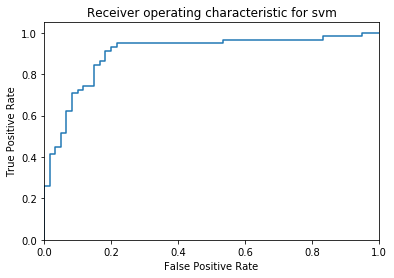

Average precision-recall score: 0.90
F1:  0.8688524590163935
F1beta:  0.8952702702702703


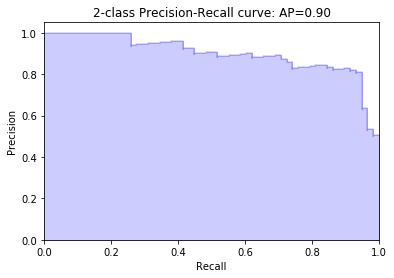

In [572]:
from sklearn import svm, datasets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from scipy.stats import expon
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer


params_svm = {'kernel': ['linear','rbf','poly','sigmoid'], 'gamma': expon(scale=0.1),
                     'C': expon(scale=10), "class_weight": ["balanced",None]}


f1score = make_scorer(f1_score)
model_svm = RandomizedSearchCV(SVC(),params_svm,scoring =f1score ,cv = 10,n_jobs = -1)

rs_results_svm = model_svm.fit(X_train, y_train)
y_true, y_pred = y_test, model_svm.predict(X_test)

print("Best score : ",rs_results_svm.best_score_)
print("Best estimator : ",rs_results_svm.best_estimator_)
print("Best params : ",rs_results_svm.best_params_)
print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))


# ROC CURVE

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_proba = model_svm.decision_function(X_test)


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("roc_auc_score: ",roc_auc_score(y_test, y_proba))
%matplotlib inline
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for svm')
plt.show()

#PR CURVE

# compute the average precision score

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))




print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))

y_proba1 = y_proba
y_test1 = y_test

precision1 = precision
recall1 = recall
step_kwargs1 = step_kwargs


## K-Nearest Neighbors - optimized using Randomized Search

Best score:  0.8760713722724556
Best estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')
Best params:  {'weights': 'distance', 'n_neighbors': 11, 'metric': 'manhattan'}
Classification report
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        60
           1       0.83      0.90      0.86        58

    accuracy                           0.86       118
   macro avg       0.86      0.86      0.86       118
weighted avg       0.86      0.86      0.86       118

Overall Accuracy: 0.8559322033898306
CONFUSION MATRIX
[[49 11]
 [ 6 52]]
roc_auc_score:  0.943103448275862


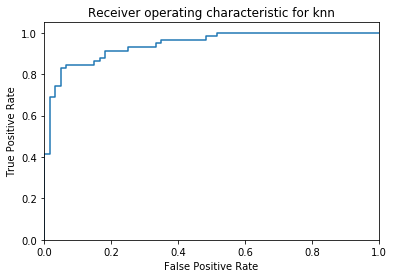

Average precision-recall score: 0.95
F1:  0.8595041322314049
F1beta:  0.8813559322033897


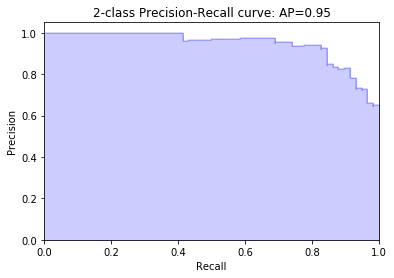

In [593]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np
from random import randint
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

params_knn = {'n_neighbors': [randint(2,11)],
              'weights':['uniform','distance'],
              'metric':['euclidean','manhattan'] }

f1score = make_scorer(f1_score)
model_knn = RandomizedSearchCV(KNeighborsClassifier(),params_knn, scoring = f1score,cv = 10, n_jobs = -1)

rs_results_knn = model_knn.fit(X_train, y_train)
y_true, y_pred = y_test, model_knn.predict(X_test)

print("Best score: ", rs_results_knn.best_score_)
print("Best estimator: ",rs_results_knn.best_estimator_)
print("Best params: ", rs_results_knn.best_params_)

print("Classification report")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_proba = model_knn.predict_proba(X_test)[:,1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("roc_auc_score: ", roc_auc_score(y_test, y_proba))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for knn')
plt.show()


#PR CURVE

# compute the average precision score

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))


y_proba2 = y_proba
y_test2 = y_test

precision2 = precision
recall2 = recall
step_kwargs2 = step_kwargs

## Logistic Regression - optimized using Randomized Search

Best score:  0.8542174017034004
Best estimator:  LogisticRegression(C=0.7596961587590496, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Best params:  {'penalty': 'l2', 'C': 0.7596961587590496}
Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        60
           1       0.82      0.91      0.86        58

    accuracy                           0.86       118
   macro avg       0.86      0.86      0.86       118
weighted avg       0.86      0.86      0.86       118

Overall Accuracy: 0.8559322033898306
CONFUSION MATRIX
[[48 12]
 [ 5 53]]
roc_auc_score:  0.9008620689655172


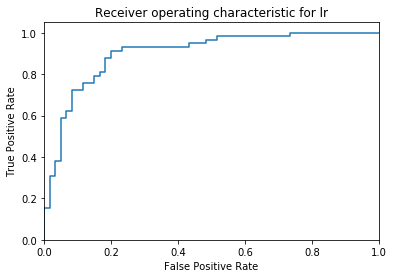

Average precision-recall score: 0.89
F1:  0.8617886178861788
F1beta:  0.8922558922558922


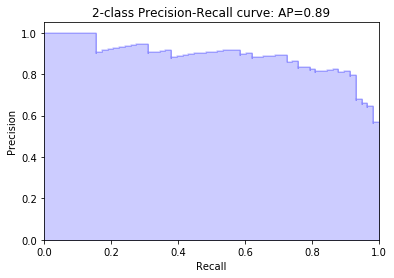

In [614]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

C_range = np.random.normal(1, 0.2, 10).astype(float)
C_range[C_range < 0] = 0.0001

penalty = ['l1', 'l2']

params = {'penalty': penalty, 'C': C_range}

f1score = make_scorer(f1_score)
model_lr = RandomizedSearchCV(LogisticRegression(), params, scoring = f1score, cv=10, n_jobs = -1)

rs_results_lr = model_lr.fit(X_train,y_train)
y_true, y_pred = y_test, model_lr.predict(X_test)

print("Best score: ", rs_results_lr.best_score_)
print("Best estimator: ",rs_results_lr.best_estimator_)
print("Best params: ",rs_results_lr.best_params_)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_proba = model_lr.predict_proba(X_test)[:,1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("roc_auc_score: ",roc_auc_score(y_test, y_proba))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for lr')
plt.show()

#PR CURVE

# compute the average precision score

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))

y_proba3 = y_proba
y_test3 = y_test

precision3 = precision
recall3 = recall


## Random Forests - Optimized using Randomized Search

Best score:  0.8982065351501279
Best estimator:  RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=85,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best params:  {'n_estimators': 85, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 6, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}
Classification report: 
              precision    recall  f1-score   support

           0       0.93      0.83      0.88        60
           1       0.84      0.93      0.89        58

    accuracy                           0.88       118
   macro avg       0.88      0.88      0.88       118
we

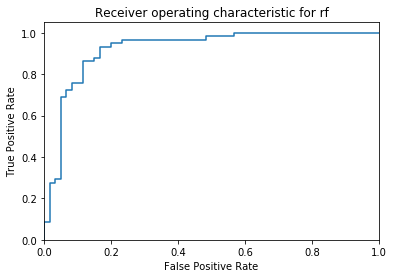

Average precision-recall score: 0.89
F1:  0.8852459016393444
F1beta:  0.9121621621621621


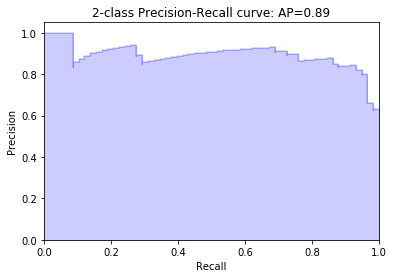

In [637]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
from random import randint
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

params_rf = {"n_estimators": [randint(10,100)], "max_features": [randint(2,10)], "min_samples_split": [randint(2,10)], "min_samples_leaf": [randint(2,10)], 
             "max_depth": [2,3,None],"bootstrap": [True, False], "criterion": ["gini", "entropy"]}

f1score = make_scorer(f1_score)
model_rf = RandomizedSearchCV(RandomForestClassifier(), params_rf, scoring = f1score, cv=10, n_jobs = -1)

rs_results_rf = model_rf.fit(X_train,y_train)
y_true, y_pred = y_test, model_rf.predict(X_test)

print("Best score: ", rs_results_rf.best_score_)
print("Best estimator: ",rs_results_rf.best_estimator_)
print("Best params: ",rs_results_rf.best_params_)

print("Classification report: ")
print(classification_report(y_true, y_pred))

print ("Overall Accuracy:", accuracy_score(y_true, y_pred))

#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("CONFUSION MATRIX")
print(confusion_matrix(y_true,y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_proba = model_rf.predict_proba(X_test)[:,1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("roc_auc_score: ",roc_auc_score(y_test, y_proba))

%matplotlib inline
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for rf')
plt.show()

#PR CURVE

# compute the average precision score

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


print("F1: ",f1_score(y_true, y_pred))
print("F1beta: ",fbeta_score(y_true, y_pred,beta = 2))

y_proba4 = y_proba
y_test4 = y_test

precision4 = precision
recall4 = recall

# Overlapping receiver operating characteristics (ROC) curves

roc_auc_score SVM:  0.9
roc_auc_score KNN:  0.943103448275862
roc_auc_score LR:  0.9008620689655172
roc_auc_score RF:  0.9224137931034483


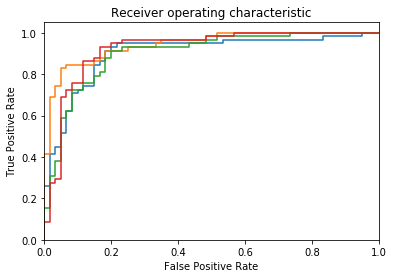

In [638]:
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()
for i in range(2):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test1, y_proba1)
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

fpr_knn = dict()
tpr_knn= dict()
roc_auc_knn = dict()
for i in range(2):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test2, y_proba2)
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])
    
fpr_lr = dict()
tpr_lr= dict()
roc_auc_lr = dict()
for i in range(2):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test3, y_proba3)
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])
    
fpr_rf = dict()
tpr_rf= dict()
roc_auc_rf = dict()
for i in range(2):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test4, y_proba4)
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

    
print("roc_auc_score SVM: ",roc_auc_score(y_test1, y_proba1))
print("roc_auc_score KNN: ",roc_auc_score(y_test2, y_proba2))
print("roc_auc_score LR: ",roc_auc_score(y_test3, y_proba3))
print("roc_auc_score RF: ",roc_auc_score(y_test4, y_proba4))

%matplotlib inline
plt.figure()
plt.plot(fpr_svm[1], tpr_svm[1])
plt.plot(fpr_knn[1], tpr_knn[1])
plt.plot(fpr_lr[1], tpr_lr[1])
plt.plot(fpr_rf[1], tpr_rf[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()


# Overlapping PR curves

Average precision-recall score SVM: 0.90
Average precision-recall score KNN: 0.95
Average precision-recall score LR: 0.89
Average precision-recall score RF: 0.89


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.89')

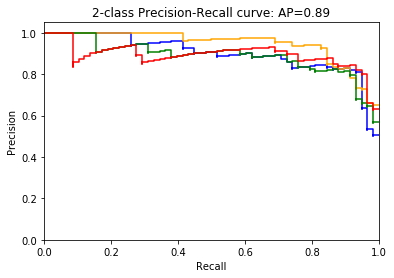

In [639]:
from sklearn.metrics import average_precision_score
average_precision_svm = average_precision_score(y_test1, y_proba1)

print('Average precision-recall score SVM: {0:0.2f}'.format(
      average_precision_svm))

average_precision_knn = average_precision_score(y_test2, y_proba2)

print('Average precision-recall score KNN: {0:0.2f}'.format(
      average_precision_knn))


average_precision_lr = average_precision_score(y_test3, y_proba3)

print('Average precision-recall score LR: {0:0.2f}'.format(
      average_precision_lr))

average_precision_rf = average_precision_score(y_test4, y_proba4)

print('Average precision-recall score RF: {0:0.2f}'.format(
      average_precision_rf))


#plot the precision-recall curve

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

plt.step(recall1, precision1, color='blue',
         where='post')


plt.step(recall2, precision2, color='orange', 
         where='post')

plt.step(recall3, precision3, color='green', 
         where='post')

plt.step(recall4, precision4, color='red', 
         where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))